In [2]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats

# statsmodels doesn't support discremenant analysis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

warnings.filterwarnings("ignore")



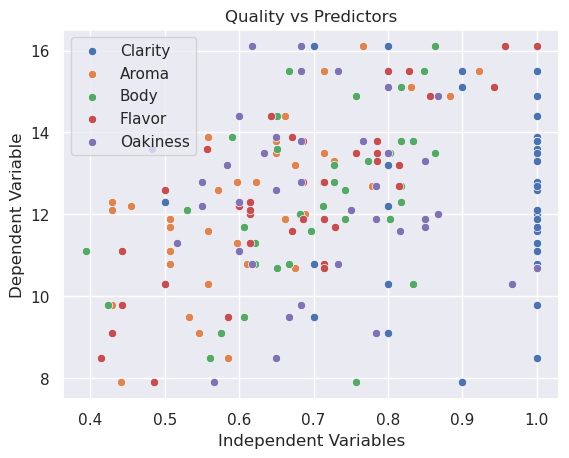

<Figure size 640x480 with 0 Axes>

In [25]:
#exploratory analysis
#plot quality against the quantitative as scatter plots and as a histogram for the qualitativeModel:                    
df = pd.read_table("wine.txt", sep="\t")

independent_vars = df.columns[1:]
sns.set_theme(style="darkgrid")
df_quant = df.drop(columns=["Region"])
for col in df_quant.columns[:-1]:
    sns.scatterplot(
    x=df_quant[col] / df_quant[col].max(), 
    y=df['Quality'], 
    label=col
    )
plt.xlabel('Independent Variables')
plt.legend()
plt.ylabel('Dependent Variable')
plt.title('Quality vs Predictors')
plt.grid(True)
plt.show()
plt.savefig("scatter.png")
#notes
#clarity seems to be the least correlated w/ the quality of the wine, it also seems to be a quasi-factor variable in itself
#the other variables are visually similar in their plot

4.768421052631578

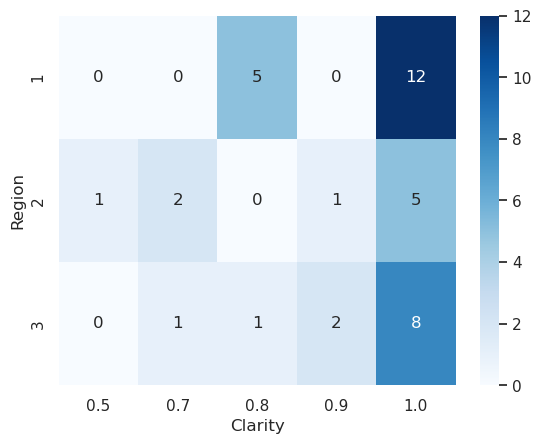

In [57]:
clarity_by_region = pd.crosstab(index=df["Region"], columns=df["Clarity"])
cbr = sns.heatmap(clarity_by_region, annot=True, cmap='Blues')
plt.savefig("qualityByRegion.png")

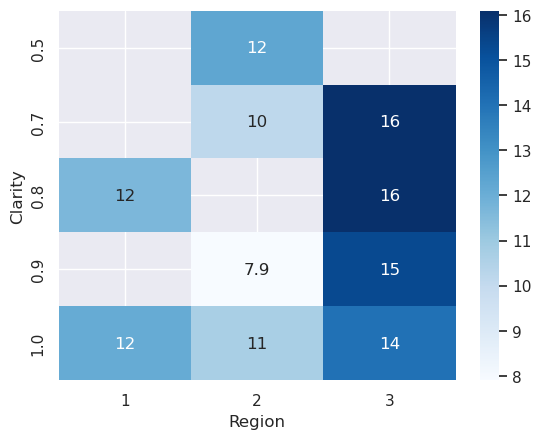

In [58]:
clarity_by_region = df.pivot_table(columns="Region", index="Clarity", values="Quality", aggfunc='mean')

qcbr = sns.heatmap(clarity_by_region, annot=True, cmap='Blues')
plt.savefig("qualityByRegionByQuality.png")

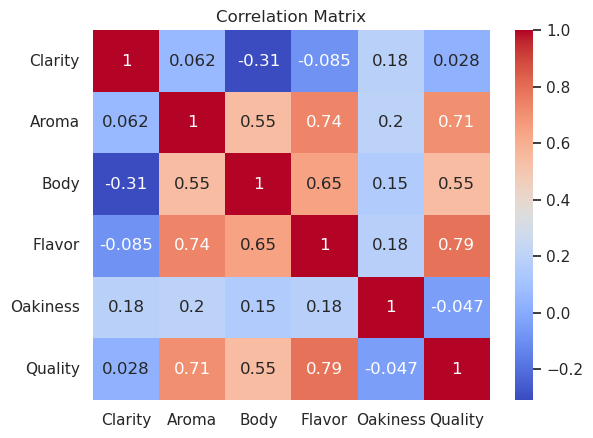

In [23]:
correlation_matrix = df_quant.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



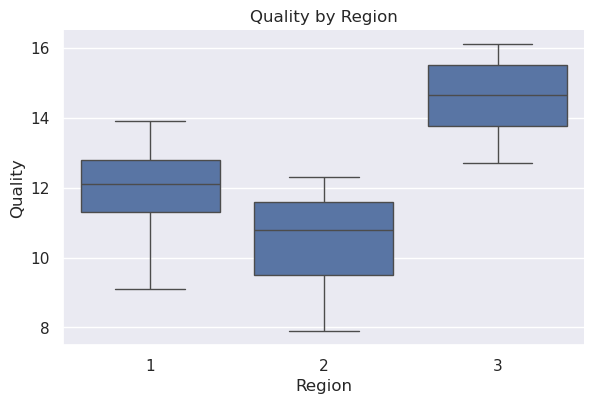

In [17]:
sns.catplot(data=df, x='Region', y='Quality', kind='box', height=4, aspect=1.5)
plt.title('Quality by Region')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                Quality   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                   0.02914
Date:                Sun, 23 Feb 2025   Prob (F-statistic):              0.865
Time:                        14:54:02   Log-Likelihood:                -80.589
No. Observations:                  38   AIC:                             165.2
Df Residuals:                      36   BIC:                             168.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0034      2.561      4.687      0.0

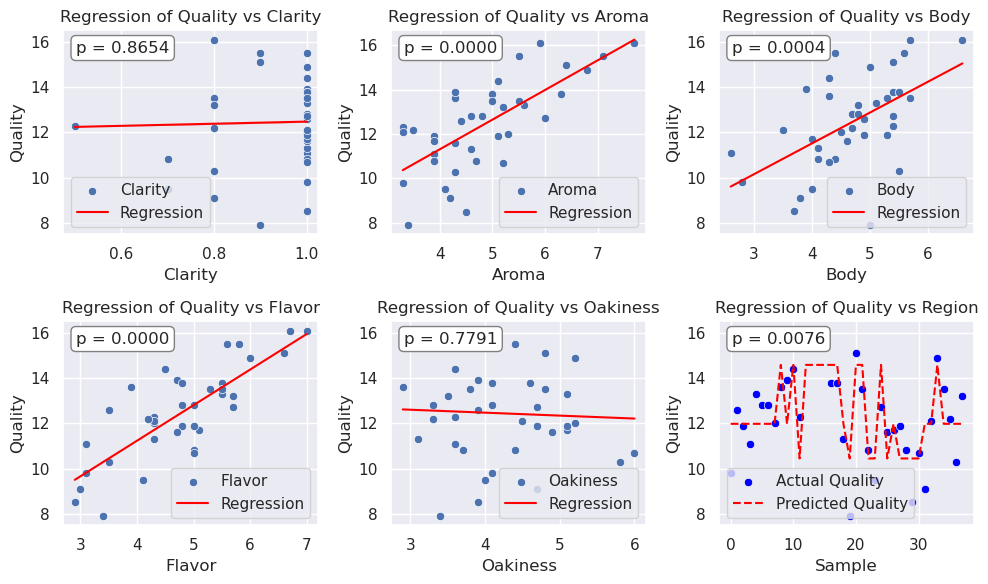

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

# Initialize the figure and define grid layout
num_cols = len(df_quant.columns[:-1]) + 1  # +1 for the categorical regression
cols = 3  # Number of columns in grid
rows = int(np.ceil(num_cols / cols))  # Number of rows required
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows), sharey=False)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Store regression models
regressions = []

# Loop through each quantitative column
for i, col in enumerate(df_quant.columns[:-1]):
    X = df_quant[[col]]
    y = df_quant["Quality"]
    X = sm.add_constant(X)
    reg = sm.OLS(y, X).fit()
    print(reg.summary())
    regressions.append(reg)
    
    # Scatter plot
    sns.scatterplot(ax=axes[i], x=df_quant[col], y=df_quant['Quality'], label=col)
    
    # Plot regression line
    sns.lineplot(ax=axes[i], x=X[col], y=reg.predict(X), color='red', label='Regression')
    
    # Extract p-value for the predictor
    p_value = reg.pvalues[1]  # p-value for the predictor (excluding constant)
    
    # Display p-value on top of the graph
    axes[i].text(0.05, 0.95, f'p = {p_value:.4f}', 
                 transform=axes[i].transAxes, 
                 fontsize=12, 
                 verticalalignment='top',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray'))
    
    # Label axes and title
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Quality")
    axes[i].set_title(f'Regression of Quality vs {col}')
    axes[i].legend()

# Categorical regression for Region
reg = smf.ols('Quality ~ C(Region)', data=df).fit()
y_hat = reg.predict(df[['Region']])
regressions.append(reg)
print(reg.summary())

# Plot categorical regression in the next subplot
ax_index = len(df_quant.columns) - 1
sns.scatterplot(ax=axes[ax_index], x=range(len(df['Quality'])), y=df['Quality'], color='blue', label='Actual Quality')
sns.lineplot(ax=axes[ax_index], x=range(len(df['Quality'])), y=y_hat, color='red', label='Predicted Quality', linestyle='--')

# Display p-value for the categorical regression
p_value_region = reg.pvalues[1]  # Assuming C(Region)[T.level] is the first predictor
axes[ax_index].text(0.05, 0.95, f'p = {p_value_region:.4f}', 
                    transform=axes[ax_index].transAxes, 
                    fontsize=12, 
                    verticalalignment='top',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray'))

axes[ax_index].set_xlabel('Sample')
axes[ax_index].set_ylabel('Quality')
axes[ax_index].set_title('Regression of Quality vs Region')
axes[ax_index].legend()

# Remove any empty subplots
for j in range(ax_index + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure before showing it
fig.savefig("latex/singleregression.png", dpi=100)  # Use the main 'fig' object and set a higher DPI


In [106]:
#b)
#full model
df = pd.read_table("wine.txt",sep="\t")
df['Region'] = df['Region'].astype("category")
reg = smf.ols('Quality ~ C(Region) + Clarity + Aroma + Body + Flavor + Oakiness ', data=df).fit()
print(reg.summary().as_latex())
#full model with interaction with region
reg_interaction = smf.ols('Quality ~ Clarity * Region + Aroma * Region + Body * Region + Flavor * Region + Oakiness * Region', data=df).fit()
print(reg_interaction.summary())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &     Quality      & \textbf{  R-squared:         } &     0.838   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.800   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     22.10   \\
\textbf{Date:}             & Sun, 23 Feb 2025 & \textbf{  Prob (F-statistic):} &  3.29e-10   \\
\textbf{Time:}             &     16:14:19     & \textbf{  Log-Likelihood:    } &   -46.070   \\
\textbf{No. Observations:} &          38      & \textbf{  AIC:               } &     108.1   \\
\textbf{Df Residuals:}     &          30      & \textbf{  BIC:               } &     121.2   \\
\textbf{Df Model:}         &           7      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                        & \textbf{coef}

In [110]:
#removing predictors for which all slopes have p < 0.05
reg_reduced = smf.ols('Quality ~ Region + Flavor', data=df).fit()
print(reg_reduced.summary())

reg_reduced_most_signifcant_clarity = smf.ols('Quality ~ Flavor * Region + Clarity * Region', data=df).fit()
print(reg_reduced.summary())

reg_reduced_w_body = smf.ols('Quality ~ Clarity * Region + Flavor * Region + Body * Region', data=df).fit()
print(reg_reduced_w_body.summary())


                            OLS Regression Results                            
Dep. Variable:                Quality   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     53.13
Date:                Sun, 23 Feb 2025   Prob (F-statistic):           6.36e-13
Time:                        16:24:06   Log-Likelihood:                -47.576
No. Observations:                  38   AIC:                             103.2
Df Residuals:                      34   BIC:                             109.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.0943      0.791      8.

In [119]:
#Comparing the full and reduced model with anova
anova_comparison = sm.stats.anova_lm(reg_reduced, reg_interaction)
#print(anova_comparison)

X_new = pd.DataFrame({
    'Region': [1],
    'Flavor' : [np.mean(df["Flavor"])]
    })

pred = reg_reduced.get_prediction(X_new) 
pred_summary = pred.summary_frame(alpha=0.05)
print(pred_summary[['mean',
                    'mean_ci_lower',
                    'mean_ci_upper',
                    'obs_ci_lower',
                    'obs_ci_upper']])

       mean  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  12.41371      11.951516      12.875903     10.537749      14.28967


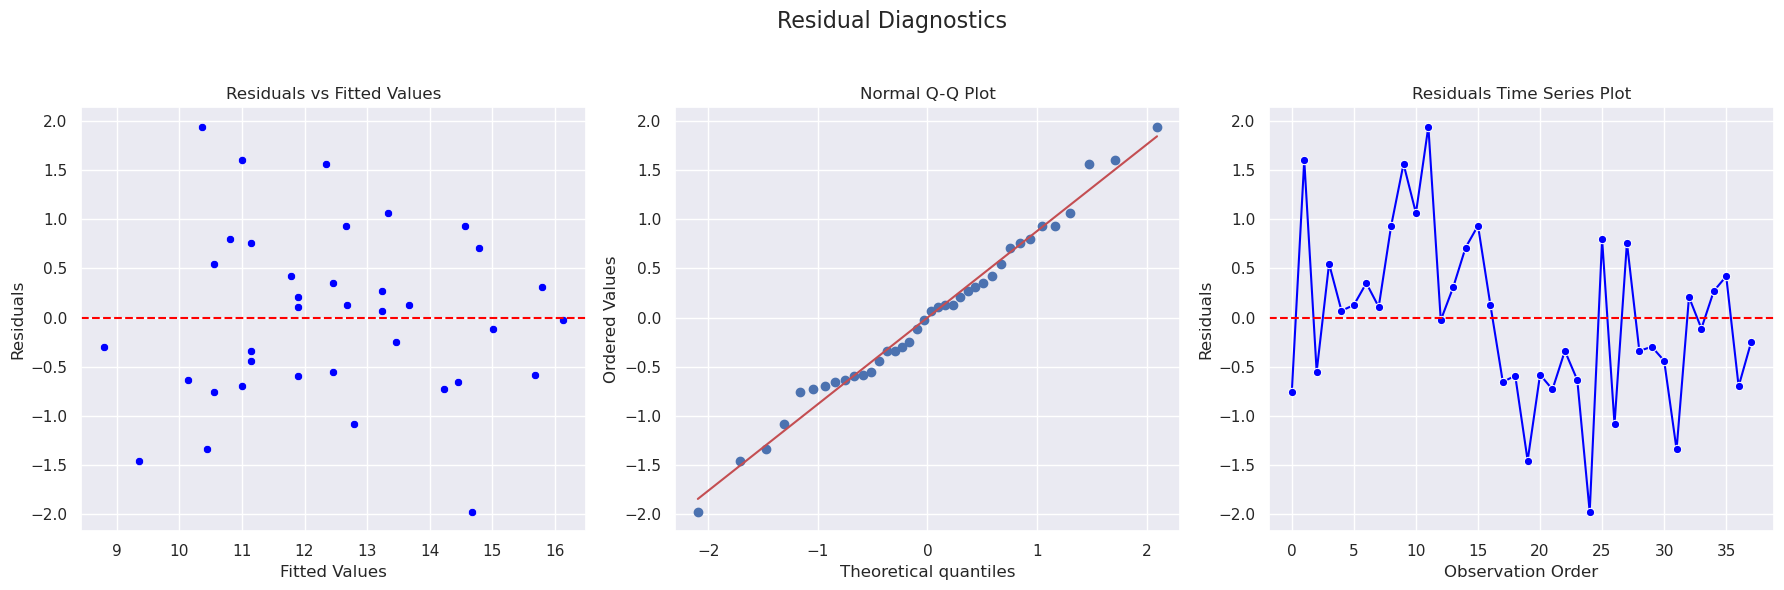

In [101]:
# Residual diagnostics
residuals = reg_reduced.resid
fitted_values = reg_reduced.fittedvalues

# Initialize the figure for residual diagnostics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Residual Diagnostics', fontsize=16)
# Categorical regression for Region (used for residual diagnostics)
# 1. Residuals vs Fitted Values
sns.scatterplot(ax=axes[0], x=fitted_values, y=residuals, color='blue')
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted Values')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].grid(True)

# 2. Normal Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Normal Q-Q Plot')
axes[1].grid(True)

# 3. Residuals Time Series Plot
sns.lineplot(ax=axes[2], x=range(len(residuals)), y=residuals, marker='o', color='blue')
axes[2].axhline(y=0, color='red', linestyle='--')
axes[2].set_title('Residuals Time Series Plot')
axes[2].set_xlabel('Observation Order')
axes[2].set_ylabel('Residuals')
axes[2].grid(True)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate the suptitle
plt.show()


(2000, 8)


<Figure size 100x50 with 0 Axes>

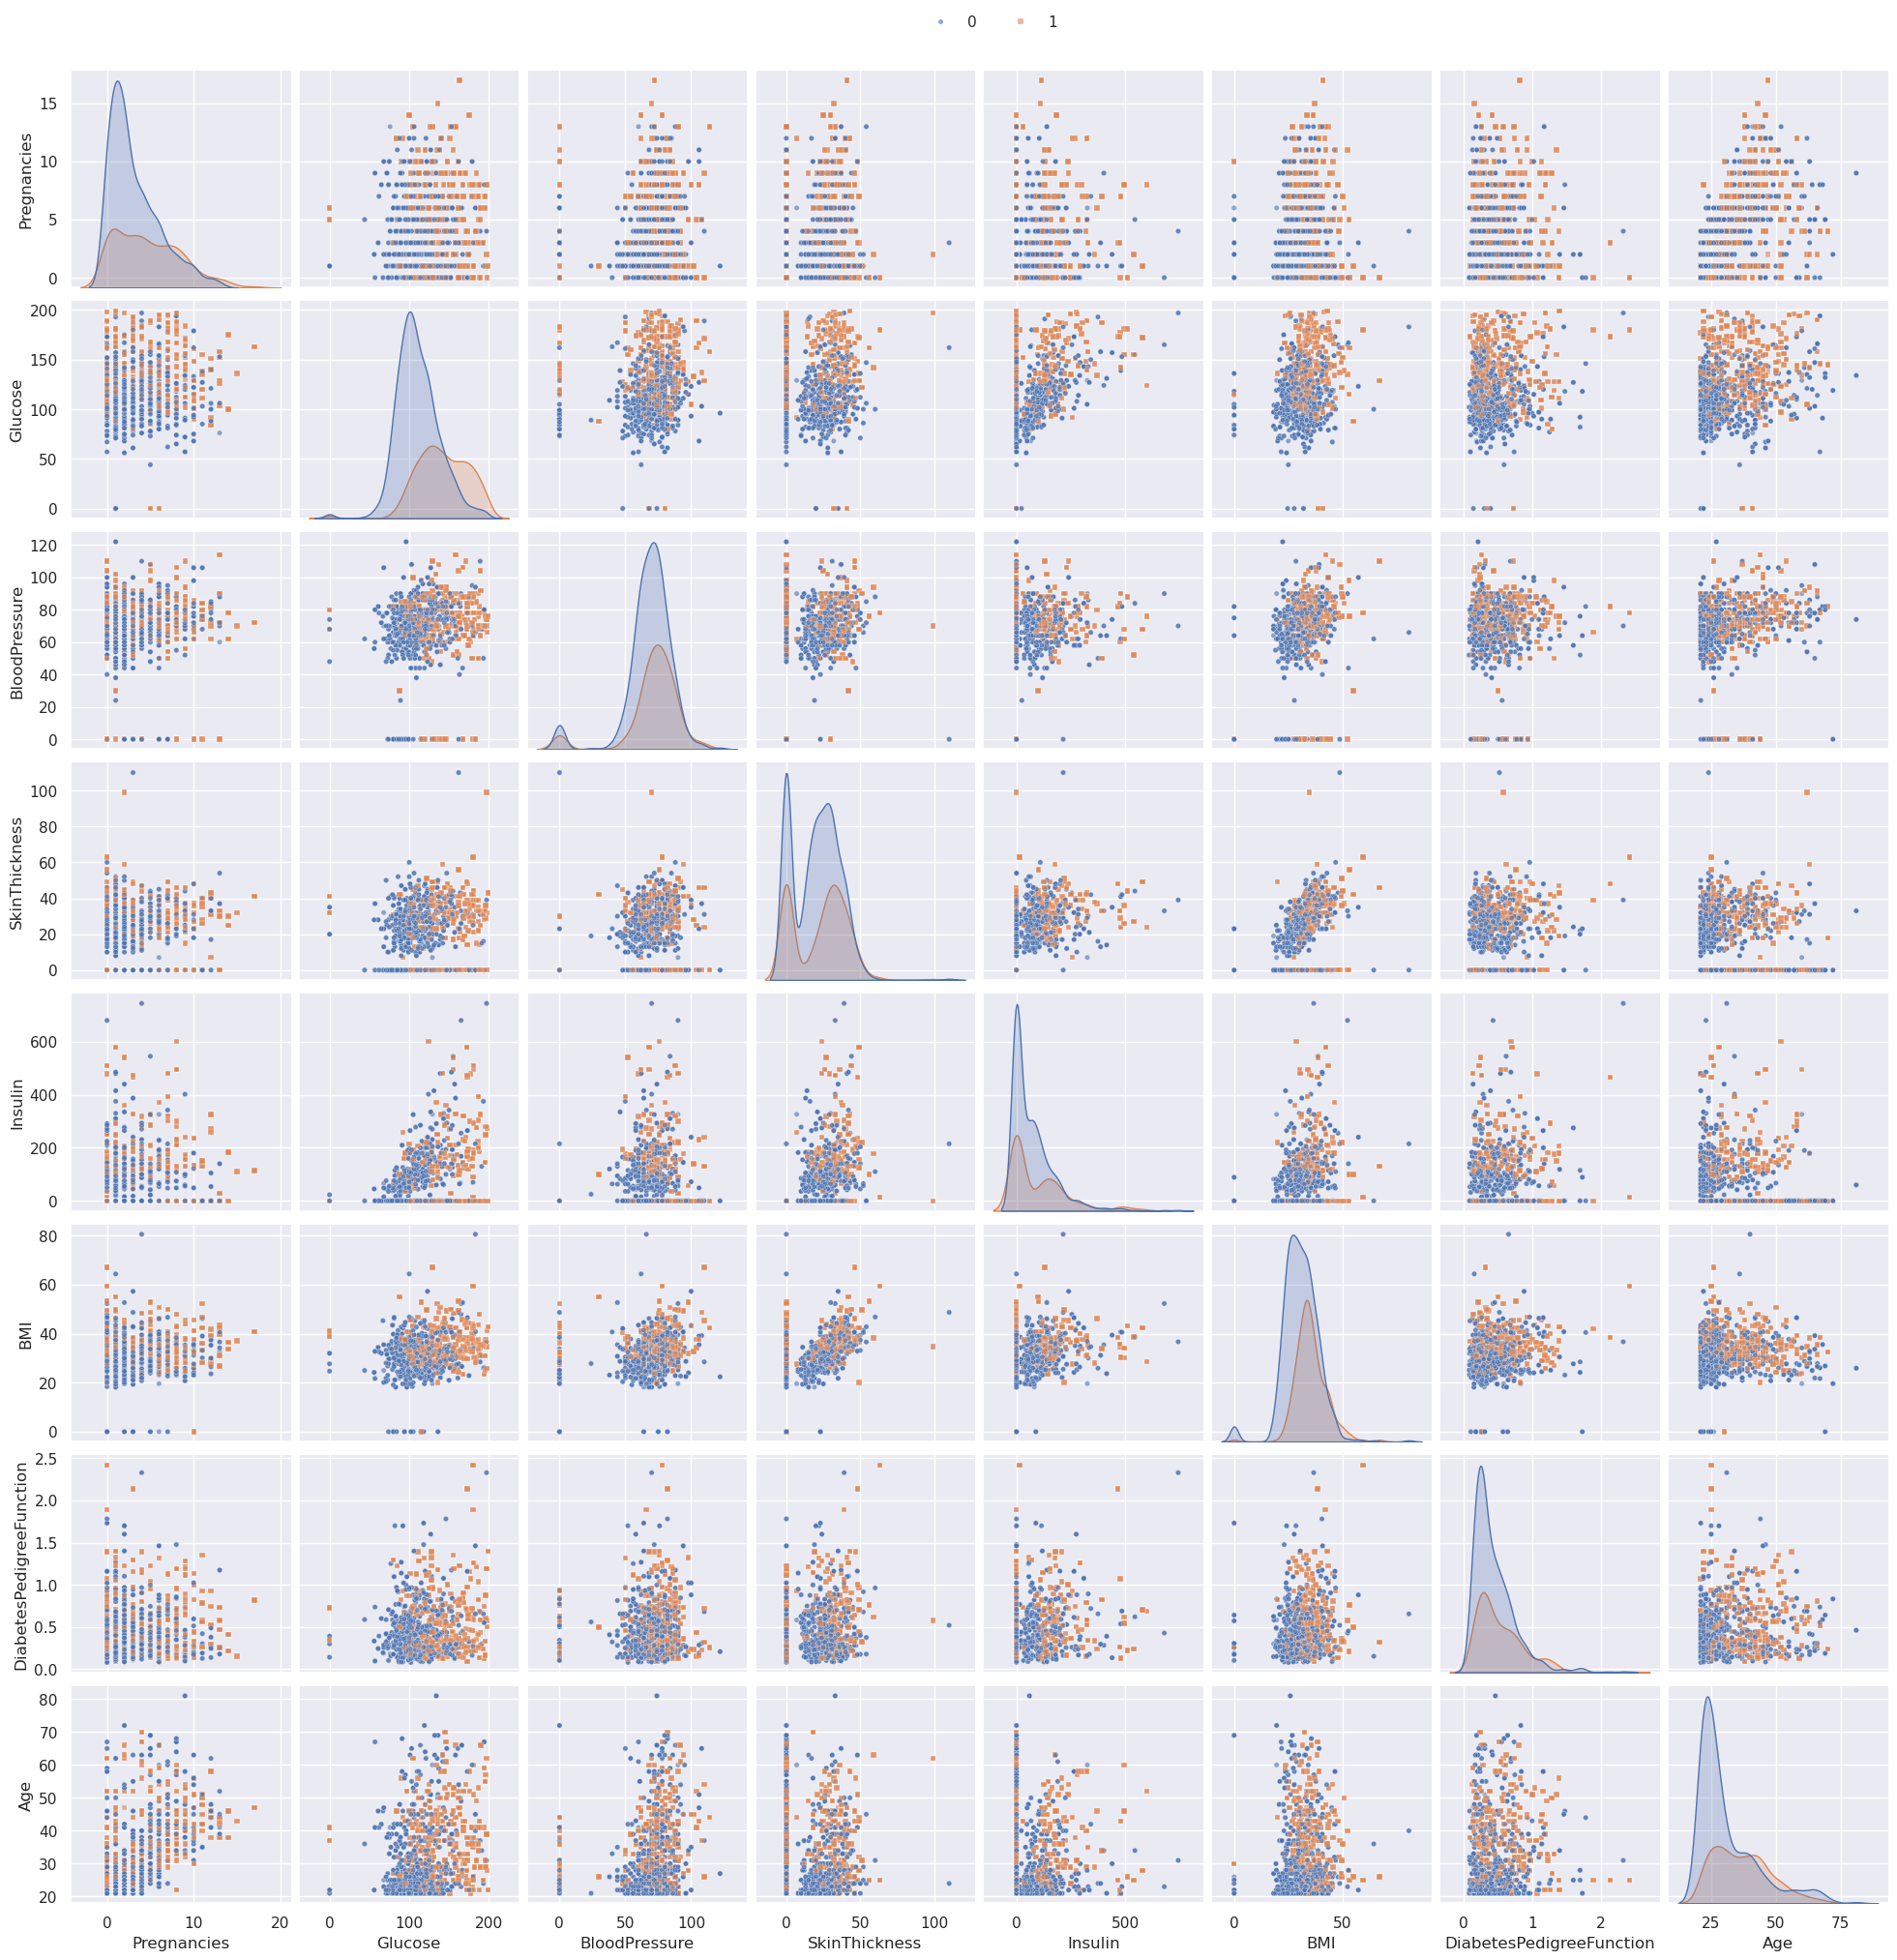

<Figure size 100x50 with 0 Axes>

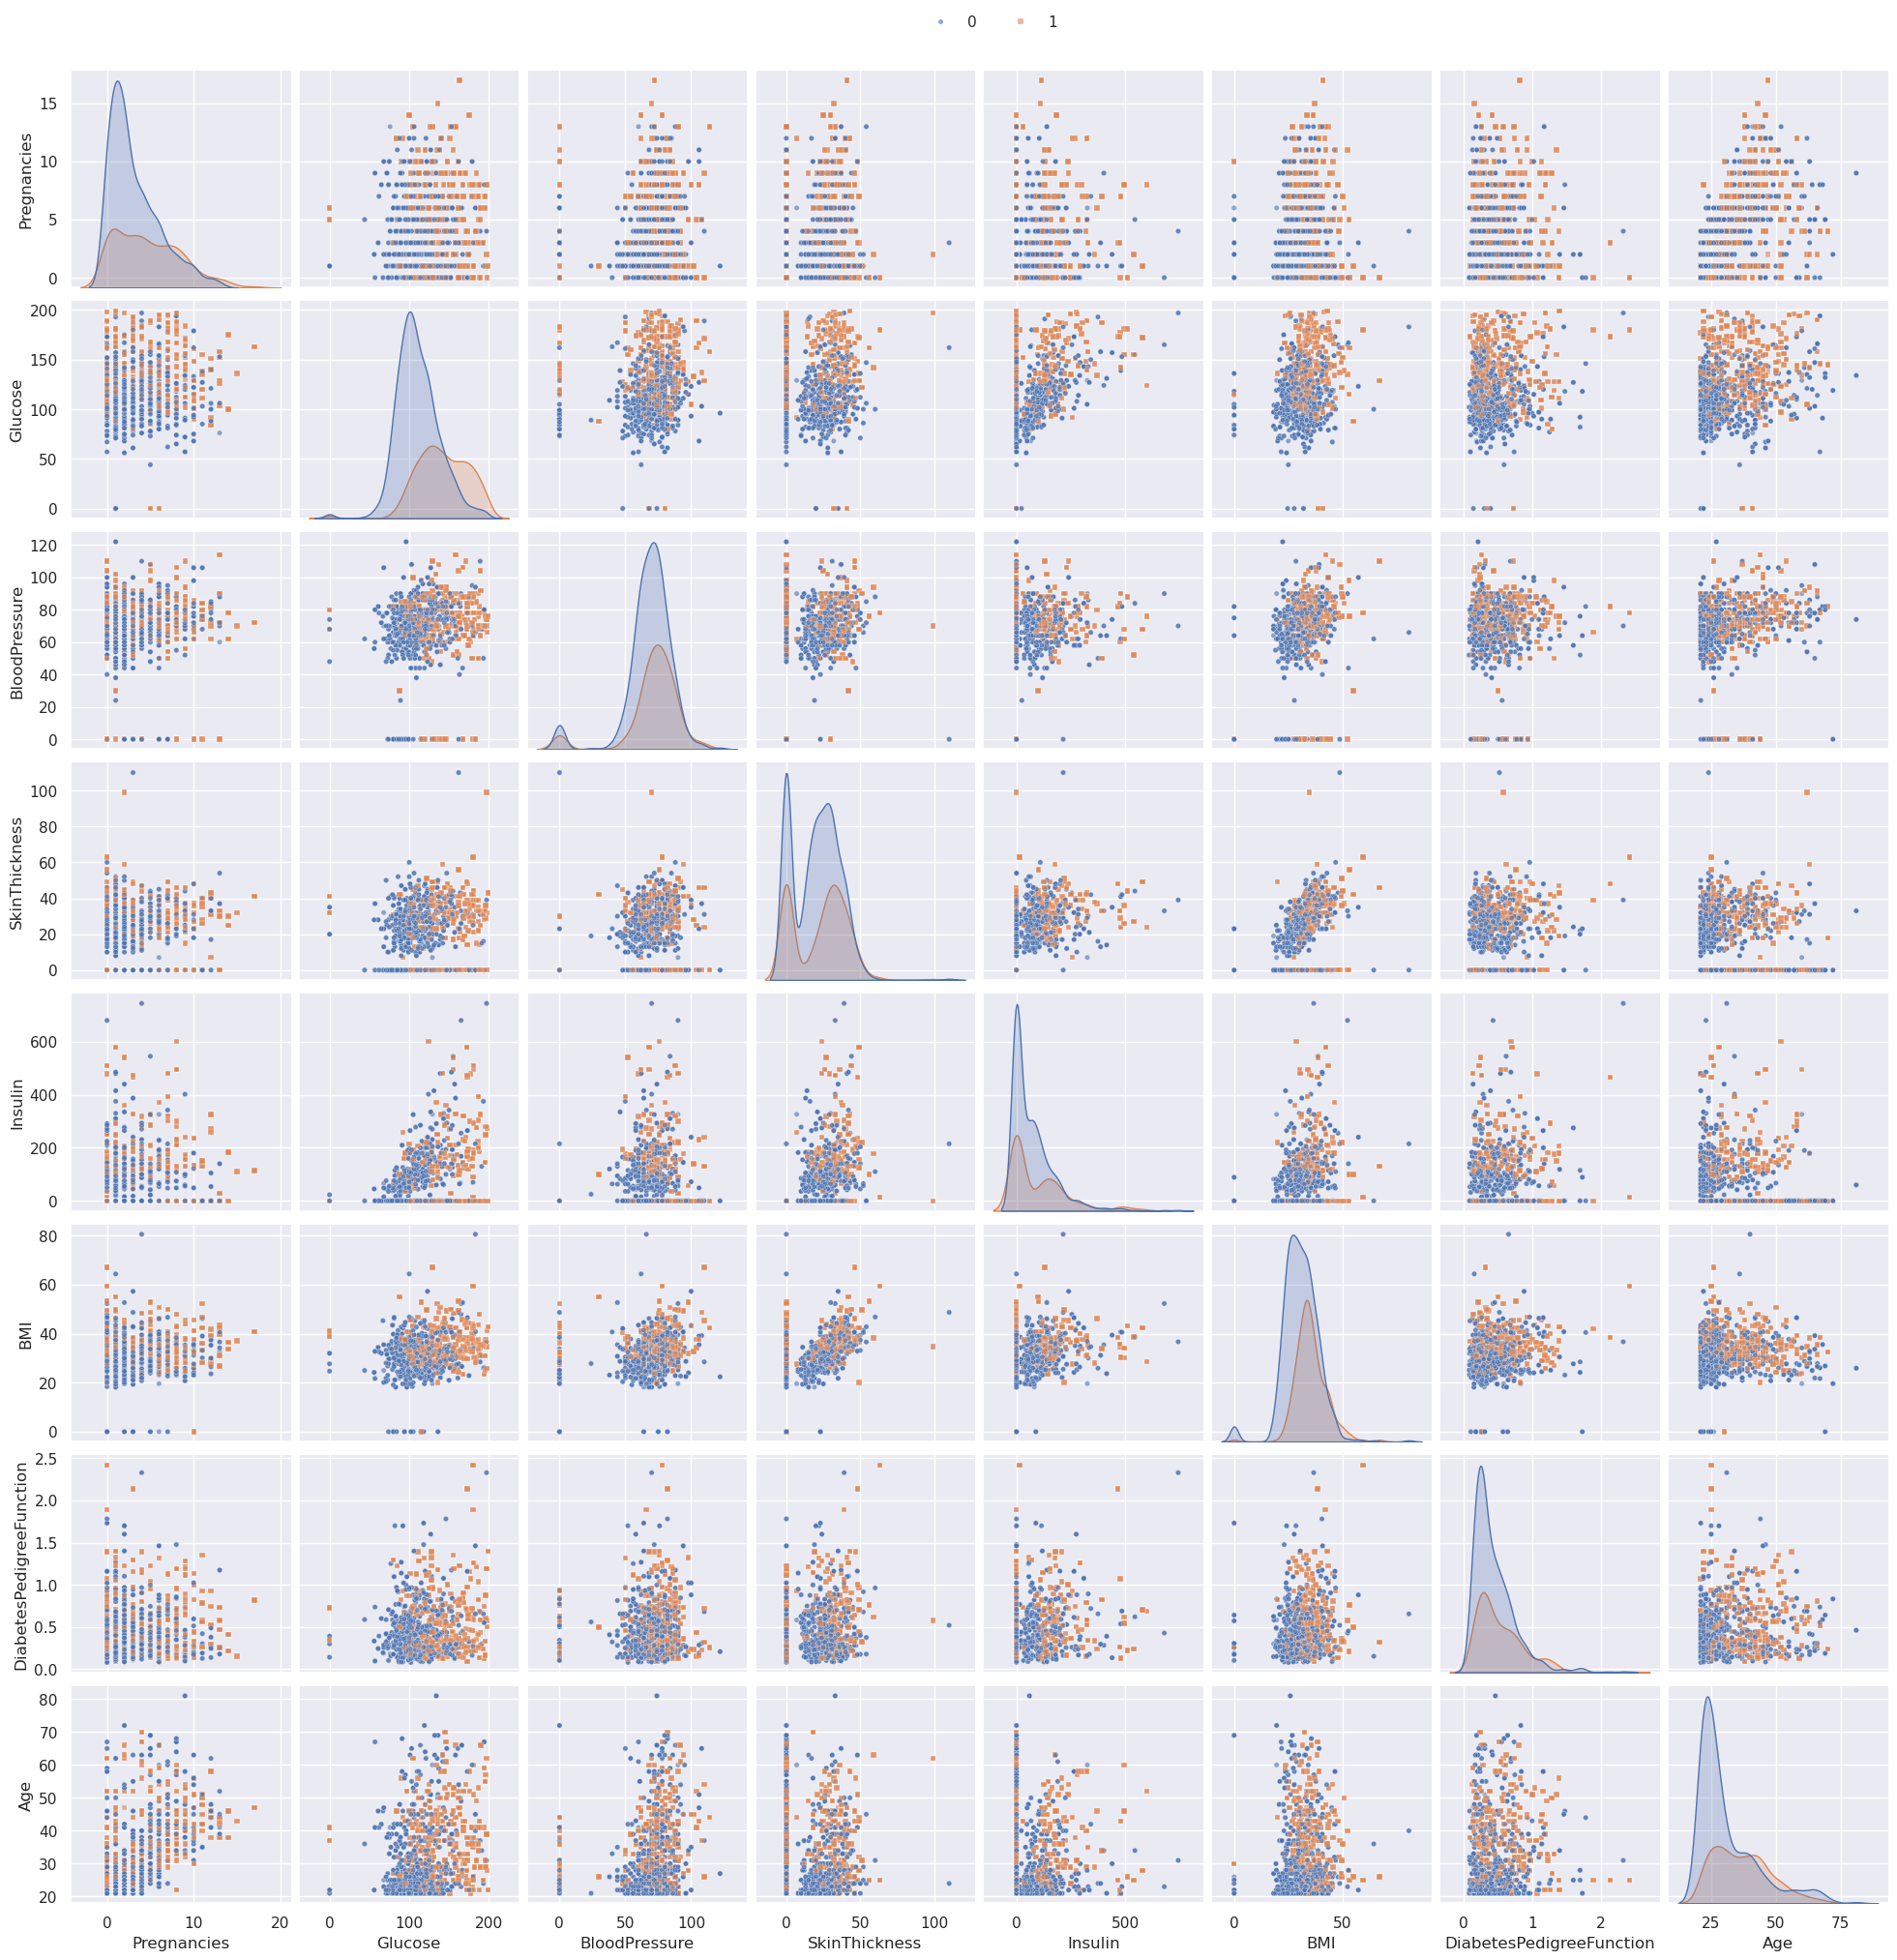

In [137]:
diabetes = pd.read_csv("diabetes.csv")
diabetes.columns = diabetes.columns.str.replace(' ','')
diabetes.columns = diabetes.columns.str.replace('\n','')
X = diabetes.drop(columns=["Outcome"])
print(X.shape)
y = LabelEncoder().fit_transform(diabetes.iloc[:, -1])
fig = plt.figure(figsize=(10, 5), dpi=10)
# Condensed pairplot
g = sns.pairplot(
    diabetes, 
    hue='Outcome', 
    markers=["o", "s"], 
    plot_kws={'s': 15, 'alpha': 0.6},  # Smaller points, more transparent
    diag_kws={'fill': True}  # Filled histograms on the diagonal
)

# Move legend to a better position
sns.move_legend(
    g, 
    "lower center",
    bbox_to_anchor=(.5, 1), 
    ncol=3, 
    title=None, 
    frameon=False
)


# Adjust layout for better spacing
diabetes = pd.read_csv("diabetes.csv")
diabetes.columns = diabetes.columns.str.replace(' ','')
diabetes.columns = diabetes.columns.str.replace('\n','')
X = diabetes.drop(columns=["Outcome"])
y = LabelEncoder().fit_transform(diabetes.iloc[:, -1])
fig = plt.figure(figsize=(10, 5), dpi=10)
# Condensed pairplot
g = sns.pairplot(
    diabetes, 
    hue='Outcome', 
    markers=["o", "s"], 
    plot_kws={'s': 15, 'alpha': 0.6},  # Smaller points, more transparent
    diag_kws={'fill': True}  # Filled histograms on the diagonal
)

# Move legend to a better position
sns.move_legend(
    g, 
    "lower center",
    bbox_to_anchor=(.5, 1), 
    ncol=3, 
    title=None, 
    frameon=False
)

# Adjust layout for better spacing
plt.savefig("pairwise.png")

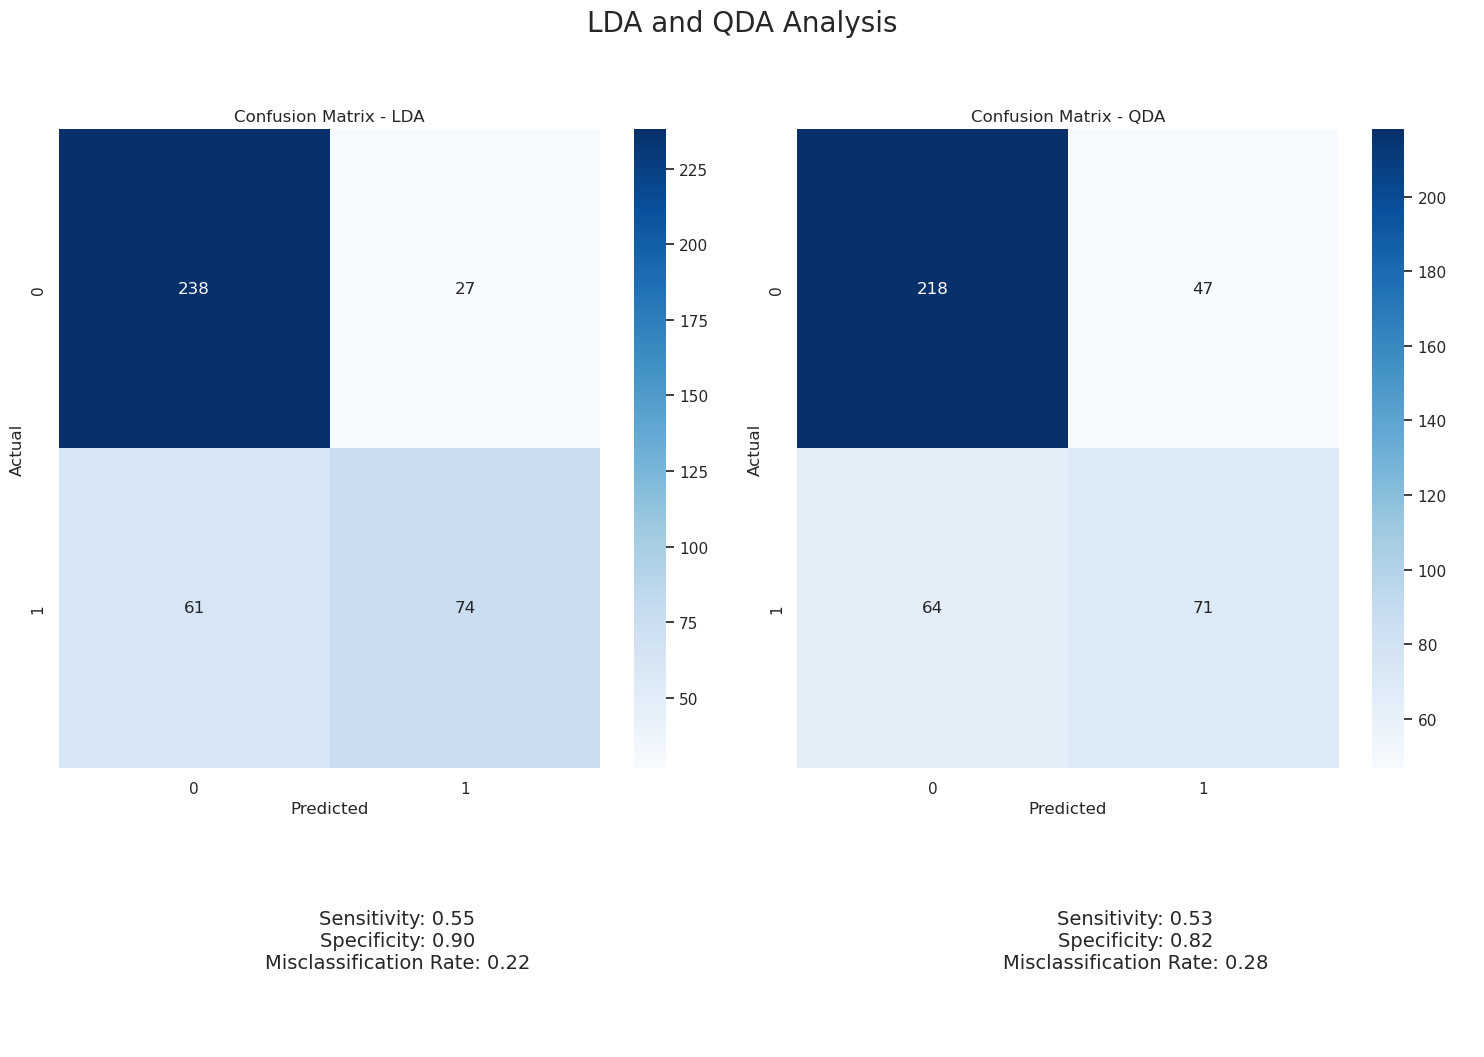

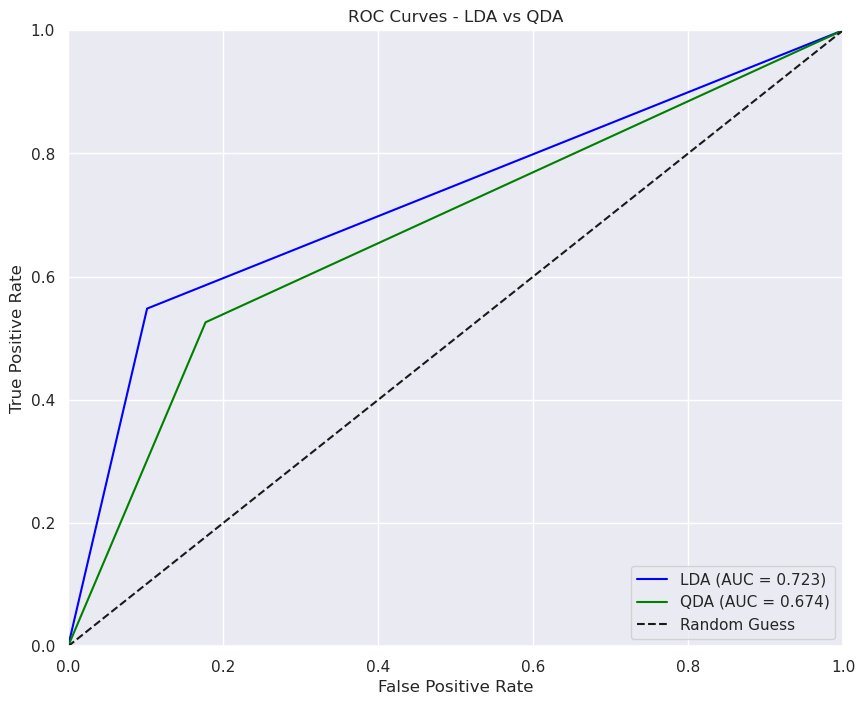

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

fig, axs = plt.subplots(2, 2, figsize=(15, 12), gridspec_kw={'height_ratios': [3, 1]})
fig.suptitle('LDA and QDA Analysis', fontsize=20)

lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
y_hat_lda = lda.predict(X_test)
y_prob_lda = lda.predict_proba(X_test)[:, 1]
y_cutoff_lda = (y_prob_lda >=0.5).astype(int)
cm_lda = confusion_matrix(y_test, y_cutoff_lda)
TN, FP, FN, TP = cm_lda.ravel()

sensitivity_lda = TP / (TP + FN)
specificity_lda = TN / (TN + FP)
misclassification_rate_lda = (FP + FN) / (TP + TN + FP + FN)

sns.heatmap(cm_lda, annot=True, fmt='d', cmap='Blues', ax=axs[0, 0])
axs[0, 0].set_title('Confusion Matrix - LDA')
axs[0, 0].set_xlabel('Predicted')
axs[0, 0].set_ylabel('Actual')

axs[1, 0].axis('off')
metrics_text_lda = (
    f"Sensitivity: {sensitivity_lda:.2f}\n"
    f"Specificity: {specificity_lda:.2f}\n"
    f"Misclassification Rate: {misclassification_rate_lda:.2f}"
)
axs[1, 0].text(0.5, 0.5, metrics_text_lda, 
               horizontalalignment='center', verticalalignment='center', 
               fontsize=14, bbox=dict(facecolor='white', alpha=0.5))

qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
y_hat_qda = qda.predict(X_test)
y_prob_qda = qda.predict_proba(X_test)[:, 1]
y_cutoff_qda = (y_prob_qda >=0.5).astype(int)

cm_qda = confusion_matrix(y_test, y_cutoff_qda)
TN, FP, FN, TP = cm_qda.ravel()

sensitivity_qda = TP / (TP + FN)
specificity_qda = TN / (TN + FP)
misclassification_rate_qda = (FP + FN) / (TP + TN + FP + FN)

sns.heatmap(cm_qda, annot=True, fmt='d', cmap='Blues', ax=axs[0, 1])
axs[0, 1].set_title('Confusion Matrix - QDA')
axs[0, 1].set_xlabel('Predicted')
axs[0, 1].set_ylabel('Actual')

axs[1, 1].axis('off')
metrics_text_qda = (
    f"Sensitivity: {sensitivity_qda:.2f}\n"
    f"Specificity: {specificity_qda:.2f}\n"
    f"Misclassification Rate: {misclassification_rate_qda:.2f}"
)
axs[1, 1].text(0.5, 0.5, metrics_text_qda, 
               horizontalalignment='center', verticalalignment='center', 
               fontsize=14, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
#plt.savefig("confusionCombined.png")

plt.figure(figsize=(10, 8))
# ROC Curve for LDA
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_cutoff_lda)
roc_auc_lda = auc(fpr_lda, tpr_lda)
plt.plot(fpr_lda, tpr_lda, label=f'LDA (AUC = {roc_auc_lda:.3f})', color='blue')

# ROC Curve for QDA
fpr_qda, tpr_qda, _ = roc_curve(y_test, y_cutoff_qda)
roc_auc_qda = auc(fpr_qda, tpr_qda)
plt.plot(fpr_qda, tpr_qda, label=f'QDA (AUC = {roc_auc_qda:.3f})', color='green')

# Random Classifier Line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Plot details
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - LDA vs QDA')
plt.legend(loc="lower right")
#plt.savefig("roccombined.png")